# Kubespot for AWS

opsZero setups up your infrastructure to be secure, scalable, cost effective. We
build your infrastructure using Google Workspace, Github, Cloudflare, AWS, and
optionally Datadog. Our goal is to build an infrastructure that scales with you
throughout your growth cycle without any issues.

 1. Google Workspace. Used as the Single Sign-On (SSO) to login to your Cloud resources. 
 2. Github. Used to store, build and deploy your code.
 2. Cloudflare. Used for cost effective CDN, Zero-Trust (alternate to VPN), and DDoS protection.
 3. AWS. Used for running your code.
 4. Datadog. Used for performance monitoring and metrics.

All of these components except for Google Workspace are configured through
Infrastructure as Code that lives within your Github Organization. Everything is
written using Terraform modules to ensure repeatability.

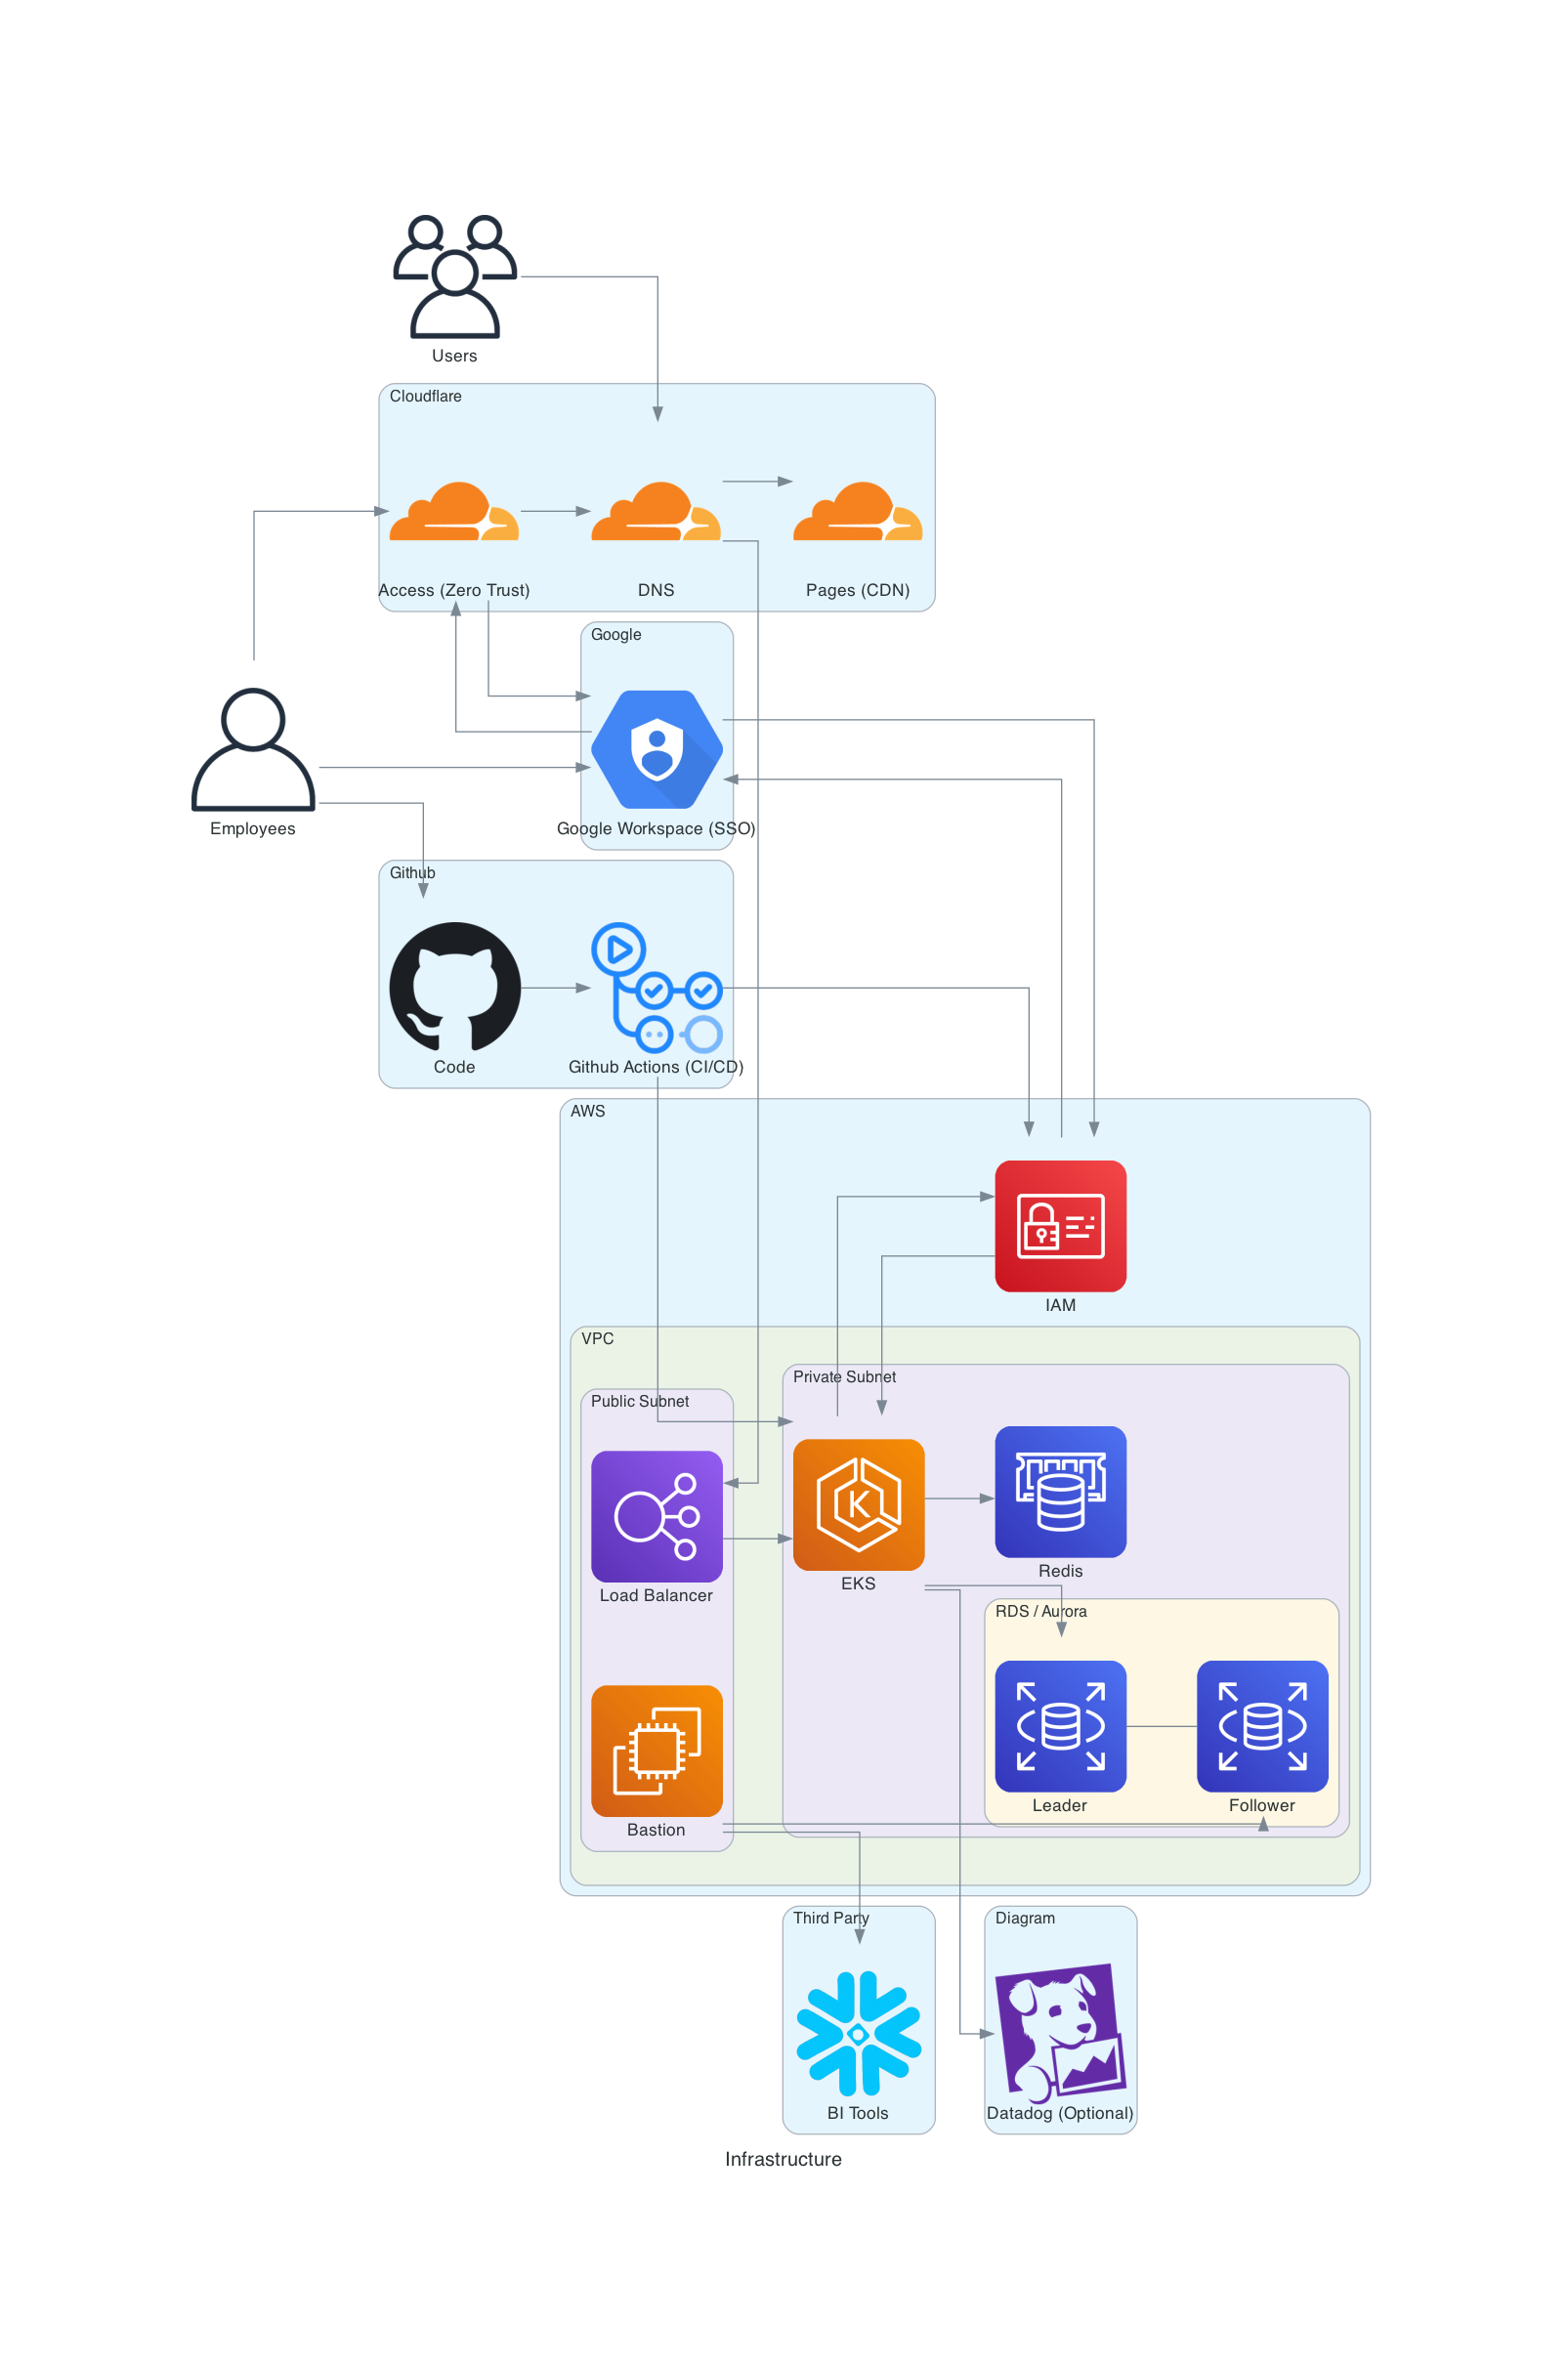

In [9]:
%%capture --no-display

from diagrams import Cluster, Diagram
from diagrams.aws.compute import EC2, ElasticKubernetesService
from diagrams.aws.database import RDS, ElastiCache
from diagrams.aws.general import OfficeBuilding, Users, User
from diagrams.aws.network import ELB, Route53
from diagrams.aws.security import IAM
from diagrams.gcp.security import Iam
from diagrams.generic.device import Mobile
from diagrams.onprem.ci import GithubActions
from diagrams.onprem.monitoring import Datadog
from diagrams.onprem.vcs import Github
from diagrams.saas.cdn import Cloudflare
from diagrams.saas.analytics import Snowflake



with Diagram("Infrastructure", show=False) as diag:
    user = Users("Users")
    employee = User("Employees")

    with Cluster("Cloudflare"):
        dns = Cloudflare("DNS")
        pages = Cloudflare("Pages (CDN)")
        access = Cloudflare("Access (Zero Trust)")

    with Cluster("Google"):
        sso = Iam("Google Workspace (SSO)")

    with Cluster("Github"):
        github = Github("Code")
        github_actions = GithubActions("Github Actions (CI/CD)")

    with Cluster("AWS"):
        iam = IAM("IAM")

        with Cluster("VPC"):
            with Cluster("Public Subnet"):
                lb = ELB("Load Balancer")

                bastion = EC2("Bastion")

            with Cluster("Private Subnet"):
                eks = ElasticKubernetesService("EKS")

                with Cluster("RDS / Aurora"):
                    db_master = RDS("Leader")
                    db_follower = RDS("Follower")
                    db_master - [db_follower]

                redis = ElastiCache("Redis")


    with Cluster("Diagram"):
        datadog = Datadog("Datadog (Optional)")

    with Cluster("Third Party"):
        bi = Snowflake("BI Tools")

    dns >> lb >> eks
    dns >> pages

    eks >> db_master
    eks >> redis
    eks >> iam >> eks
    iam >> sso >> iam

    employee >> access >> dns
    employee >> github
    employee >> sso
    access >> sso >> access

    github >> github_actions >> [iam, eks]

    eks >> datadog

    bastion >> db_follower
    bastion >> bi

    user >> dns


diag

## Google Workspace

Google Workspace provides a Single-Sign On solution, which simplifies access to
your Cloud resources by using a single set of credentials. This can be
beneficial in quickly managing user access to your infrastructure, as users can
be added or removed with ease.

 - [How to use G Suite as an external identity provider for AWS SSO](https://aws.amazon.com/blogs/security/how-to-use-g-suite-as-external-identity-provider-aws-sso/)

We can also setup other identity providers such as Okta.

## Cloudflare

Cloudflare is used for three things DNS, DDoS Protection, and Zero Trust.
Because Cloudflare provides such generous free limits we highly recommend using
them as you get access to their global network and security offering.

### DNS 

Cloudflare DNS is setup through
[terraform-cloudflare-domain](https://github.com/opszero/terraform-cloudflare-domain)
module. This module allows you to create domains on Cloudflare repeatably with
page rules to enforce https, Gmail configuration, and also AWS SES configuration
for outgoing emails.

```terraform
locals {
  subdomains = [
    {
      name    = "@"
      value   = "longtld.elb.us-west-2.amazonaws.com"
      type    = "CNAME"
      proxied = true
    },
    {
      name    = "app"
      value   = "longtlkd.elb.us-west-2.amazonaws.com"
      type    = "CNAME"
      proxied = true
    }
  ]
}

module "example_com" {
  source = "github.com/opszero/terraform-cloudflare-domain"
  domain = "example.com"
  records = local.subdomains
}
```

### Zero Trust & SASE

Zero Trust is a fancy term for a VPN replacement. We use [Cloudflare
Access](https://www.cloudflare.com/products/zero-trust/access/) to lock access
to certain DNS paths and network services requiring employee authentication
before access is granted. Again by associating access to your Google credentials
you can allowlist access to certain resources.



## AWS

Our configuration of AWS uses best practices and is configured through [Kubespot
for AWS](https://www.opszero.com/terraform-aws-kubespot/) an open source
Terraform package that includes best practices for SOC2, HIPAA, and PCI-DSS.
This package enforces both security while also allowing for developer
productivity.

```terraform
provider "aws" {
  profile = "awsprofile"
  region  = "us-east-1"
}

locals {
  environment_name = "kubespot-prod1"
}

module "opszero-eks" {
  source = "github.com/opszero/kubespot//eks"

  aws_profile = "awsprofile"
  zones = [
    "us-east-1c",
    "us-east-1d"
  ]

  cluster_version  = "1.24"
  environment_name = var.environment_name
  ec2_keypair      = "opszero"
  iam_users = [
    "opszero",
  ]

  cidr_block = "10.3.0.0/16"
  cidr_block_public_subnet = [
    "10.3.0.0/18",
    "10.3.64.0/18",
  ]
  cidr_block_private_subnet = [
    "10.3.128.0/18",
    "10.3.192.0/18",
  ]

  enable_nat             = false
  nodes_in_public_subnet = true

  nodes_green_instance_type    = "t3a.small"
  nodes_green_desired_capacity = 1
  nodes_green_min_size         = 1
  nodes_green_max_size         = 2
  nodes_blue_instance_type     = "t3a.small"
  nodes_blue_desired_capacity  = 0
  nodes_blue_min_size          = 0
  nodes_blue_max_size          = 0

  redis_enabled        = false
  sql_cluster_enabled  = false
  sql_instance_enabled = false

  vpc_flow_logs_enabled = false

  efs_enabled = true
}


resource "aws_ecr_repository" "kubespot" {
  name                 = "kubespot"
  image_tag_mutability = "MUTABLE"

  image_scanning_configuration {
    scan_on_push = true
  }
}
```

### IAM 

AWS IAM is configured with [MrMgr](https://github.com/opszero/terraform-aws-mrmgr) an open source library to configure IAM Roles, Github OIDC permissions, and IAM Users.

 - IAM Roles are configured to give the least access to your team while still allowing for productivity.
 - [Github OIDC](https://docs.github.com/en/actions/deployment/security-hardening-your-deployments/configuring-openid-connect-in-amazon-web-services). Github gets access to your AWS account through OIDC. AWS provides temporary tokens to Github for deployment scoped at the repository level, requiring no additional IAM users to be created.
 - IAM Users are created if needed for access outside of SSO.

### VPCs

Every environment we set up for you will be within its own VPC. You can think of
a VPC as similar to the wireless router you connect to at home. The wireless
router and cable modem act as a bridge to the outside network, and VPCs work in
a similar way. We follow best practices to set up VPCs with high security
standards that ensure all resources are created behind a NAT. A NAT acts like a
static IP that all external resources see when you send data out of your
network. If desired, we can also put things into the public subnet, although
this is not recommended except for bastions. The VPCs are even locked down
within the same AWS account, limiting intruder access to
resources.

### EKS (Kubernetes)

Environments and deployments are setup using Kubernetes. There are a range of
opinions about Kubernetes, but we have been developing and deploying software
for well over a decade and believe a well configured Kubernetes cluster will
just work and scale as your grow. We configure your Kubernetes cluster with just
the appropriate amount of built in tooling to reduce costs, be performant, and
scale. Deploy software as many times as you want during the day with no downtime
deploys.  Further, we are able to upgrade your clusters without any downtime
whatsoever.

### RDS / Aurora

Databases are either RDS or Aurora are configured with configurations for data
encryption and solid security postures.

## Datadog

Tracing Setup / Reconfigurations Datadog
Performance Monitoring
Monitoring upgrades

## Third-Party

If third-party access to your AWS resources like Hevo, Airbyte, Metabase, Mongo
Atlas, we can create bastions to provide access.

# Upgrades

## Deprecated APIs

https://github.com/doitintl/kube-no-trouble
